In [1]:
import numpy as np
from numpy import sqrt, sin, cos, pi
import matplotlib.pyplot as plt

from floquet import *

In [2]:
def quinton(matrix, figax=None, **kwargs):
    """
    Quinton Plot for a given (square) matrix
    """

    # set the matplotlib axis, or make one if not given
    if figax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    else: 
        fig, ax = figax
            
    # see if hilbert dimension is given, otherwise set to 2
    try:
        hdim = kwargs["hilbert_dim"]
    except:
        hdim = 2
        

    # Floquet matrix dimensions
    dim = matrix.shape
        
    # scaling
    if "vmax" not in kwargs.keys():
        vmax = np.max(np.abs(matrix).real)
    else:
        vmax = kwargs["vmax"]

    if "vmin" not in kwargs.keys():
        vmin = -vmax
    else:
        vmax = kwargs["vmin"]

    img = ax.imshow(matrix.real, interpolation=None, vmax=vmax, vmin=-vmax, cmap="RdBu")
    ax.axis("equal")

    # ticks
    for s in ax.set_xticks, ax.set_yticks:
        s([i-0.5 for i in range(0, matrix.shape[0]-1, hdim)])
    for s in ax.set_xticklabels, ax.set_yticklabels:
        s([])
    ax.tick_params(**{pos:False for pos in ["top", "left", "right", "bottom"]})

    # remove spines et al.
    ax.set_frame_on(False)
    
    try:
        if kwargs["thin_lines"]:
            for i in range(0, dim[1]+1):
                ax.vlines(i-0.5, -0.7, dim[1]-0.3, color="k", alpha=0.3, linewidth=0.5)
                ax.hlines(i-0.5, -0.7, dim[1]-0.3, color="k", alpha=0.3, linewidth=0.5)
    except KeyError:
        pass
                
    try:
        if kwargs["hilbert_lines"]:
            for i in range(0, dim[1]+1, hdim):
                ax.vlines(i-0.5, -0.7, dim[1]-0.3, color="k", alpha=0.3, linewidth=0.5)
                ax.hlines(i-0.5, -0.7, dim[1]-0.3, color="k", alpha=0.3, linewidth=0.5)
    except KeyError:
        pass
        
    ax.set_clip_on(True)

    if kwargs["cbar"]:
        cax = fig.add_axes([0.85, 0.2, 0.05, 0.6])
        fig.colorbar(img, cax=cax)
        
    try:
        if kwargs["inf"]:    
            for i in [-1.3, -1.0, -0.7, dim[1]-0.3, dim[1]-0.0, dim[1]+0.3]:        
                ax.plot(i, i, "ok", markersize=3)
    except KeyError:
        pass
    
    for i in range(0, dim[1], hdim):
        ax.vlines(i-0.5, i-0.5, i+hdim-0.5, linewidth=2, color="k")
        ax.vlines(i+hdim-0.5, i-0.5, i+hdim-0.5, linewidth=2, color="k")
        ax.hlines(i-0.5, i-0.5, i+hdim-0.5, linewidth=2, color="k")
        ax.hlines(i+hdim-0.5, i-0.5, i+hdim-0.5, linewidth=2, color="k")

    return ax

In [3]:
def mas_frq(hamiltonian, start, detect, frq, npoints=4096):
    """
    Calculation in frequency domain

    Parameters
    ----------
    hamiltonian : np.ndarray
        Defines the Hamiltonian under which the spin system evolves
    start : np.ndarray
        Start Operators
    detect : np.ndarray

    """

    # diagonalize
    eigenvalues, D = np.linalg.eig(hamiltonian)
    Dinv = np.linalg.inv(D)

    # chane of basis for start and detect
    start_cs_eigenbasis = Dinv @ start @ D
    detect_cs_eigenbasis = Dinv @ detect @ D
    ham = np.diag(eigenvalues)

    # dwell time
    dw = (frq[1] - frq[0]) / npoints

    # calculate frequency spectrum
    dim = ham.shape[0]

    # frequency domain calculation
    spectrum = np.zeros(npoints)
    for i in range(dim):
        for j in range(dim):

            # find intensity and position
            intensity = detect_cs_eigenbasis[i, j] * start_cs_eigenbasis[j, i]
            delta_eigenvalue = ham[j, j] - ham[i, i]
            position = int((delta_eigenvalue.real - frq[0]) // dw)

            # accumulate only if intensity is reasonable
            if np.abs(intensity) > 1e-12:
                if 0 <= position < npoints:
                    spectrum[position] += intensity.real

    return spectrum

In [6]:
def run(sx, sy, sz, mas, start_operator, fdim):

    info = f"""\
    $\delta_{{xx}}$ = {sx :.0f} Hz
    $\delta_{{yy}}$ = {sy :.0f} Hz
    $\delta_{{zz}}$ = {sz :.0f} Hz
    $\omega_{{r}}$ = {mas :.0f} Hz
    """.strip()

    # spin 1/2
    I = pauli()

    # radians
    sx, sy, sz, mas = [2 * np.pi * i for i in (sx, sy, sz, mas)]

    # reasonable frequency limits
    limits = -100000 - sz, 200000 + sx

    # construct tensors
    CS_cart = tensor_setup(sigmax=sx, sigmay=sy, sigmaz=sz)
    CS_PAS = matrix_to_sphten(CS_cart)
    T = spherical_tensor_basis("spin", coord=[0, 0, 1])

    # term on the diagonal is the isotropic part
    terms = {}
    terms[0] = CS_PAS[0, 0] * T[0, 0]

    # start and detect operators
    dect = F(n=0, fdim=fdim, term=I["p"])
    strt = start_operator
    ft = np.zeros(4096)

    # poweder averaging
    for theta in np.linspace(0, pi, 32):
        for phi in np.linspace(0, 2 * pi, 32):

            CS = rotate(CS_PAS, phi, theta, 0,)
            terms[1] = CS[2, 1] * T[2, 0] / sqrt(3)
            terms[2] = CS[2, 2] * T[2, 0] / sqrt(6)
            terms[-1] = np.matrix.getH(CS[2, 1] * T[2, 0])
            terms[-2] = np.matrix.getH(CS[2, 2] * T[2, 0])

            fmat = F(n=None, fdim=fdim, term=mas)
            for k, v in terms.items():
                fmat += F(n=k, fdim=fdim, term=v)

            out = mas_frq(fmat, strt, dect, frq=limits, npoints=4096)
            out *= sin(theta)
            ft += out

    xscale = np.linspace(-limits[0] / 2 / pi, -limits[1] / 2 / pi, 4096)
    fid = np.fft.ifft(ft)
    fid *= np.exp(-0.005 * np.arange(fid.shape[-1]))
    ft = np.fft.fft(fid)

    return xscale, ft

In [7]:
def compare(dimension):
    
    xscale, center = run(-5000, -2000, 7000, 2500, F(n=(0, 0), term=I["x"], fdim=dimension), fdim=dimension)
    xscale, diag = run(-5000, -2000, 7000, 2500, F(n=0, term=I["x"], fdim=dimension), fdim=dimension)
    
    return xscale, center, diag

In [8]:
data = {}

for i in [3, 5, 7, 9, 11]:
    data[i] = compare(i)
    print(f"Done {i}")

Done 3
Done 5
Done 7
Done 9
Done 11


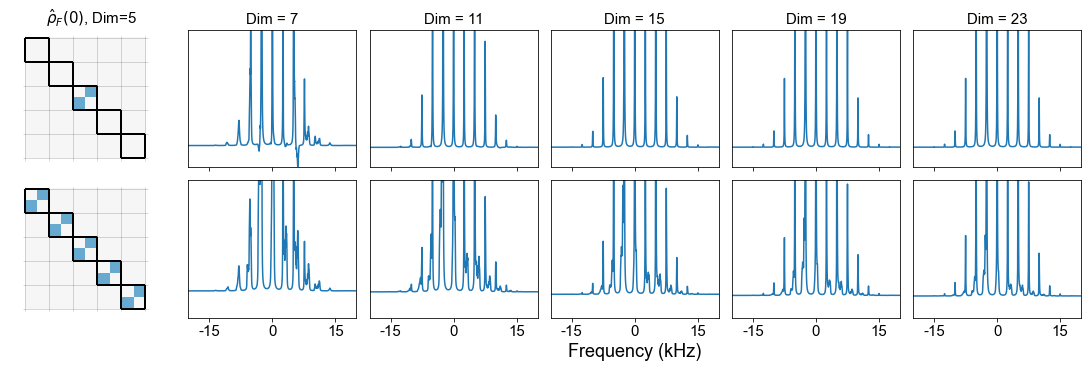

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(15, 5), 
                       constrained_layout=True, sharex="col", sharey=False)

for axis in ax.flat:
    axis.set_facecolor("white")
    for i in ["top", "bottom", "left", "right"]:
        axis.spines[i].set_edgecolor("k")


for i, (dim, d) in zip(range(1, 6), data.items()):
    
    ax[0, i].plot(d[0]/1e3, d[1].real/np.max(d[1]).real)
    ax[1, i].plot(d[0]/1e3, d[2].real/np.max(d[2]).real)
    ax[0, i].set_title(f"Dim = {dim*2+1}", fontsize=15)

for i, axis in enumerate(ax.flat):
    
    if i not in [0, 6]:
        axis.set_xlim(-20, 20)
        axis.set_ylim(-0.025, 0.2)
        axis.set_yticks([])
        axis.set_xticks([-15, 0, 15])
        axis.set_xticklabels([-15, 0, 15], fontsize=15, color="k")


quinton(F(n=(0, 0), term=I["x"], fdim=2), figax=(fig, ax[0, 0]), hilbert_lines=True, cbar=False, vmax=1)

ax[0, 0].set_title("$\hat{\\rho}_F(0)$, Dim=5", fontsize=15)
quinton(F(n=0, term=I["x"], fdim=2), figax=(fig, ax[1, 0]), hilbert_lines=True, cbar=False, vmax=1)
ax[0, 0].set_ylim(8, 1)
ax[0, 0].set_xlim(-2, 12)
ax[1, 0].set_ylim(8, 1)
ax[1, 0].set_xlim(-2, 12)
ax[1, 3].set_xlabel("Frequency (kHz)", fontsize=18, color="k")

plt.show()